In [188]:
import struct
import numpy as np
import intvalpy as ip
from functools import cmp_to_key
import matplotlib.pyplot as plt

In [189]:
def read_bin_file_with_numpy(file_path):
    with open(file_path, 'rb') as f:
        header_data = f.read(256)
        side, mode, frame_count = struct.unpack('<BBH', header_data[:4])

        frames = []
        point_dtype = np.dtype('<8H')

        for _ in range(frame_count):
            frame_header_data = f.read(16)
            stop_point, timestamp = struct.unpack('<HL', frame_header_data[:6])
            frame_data = np.frombuffer(f.read(1024 * 16), dtype=point_dtype)
            frames.append(frame_data)

        return np.array(frames)

In [190]:
def convert_to_voltage(data):
    return data / 16384.0 - 0.5


def are_intersected(x, y):
    sup = y.a if x.a < y.a else x.a
    inf = x.b if x.b < y.b else y.b
    return sup - inf <= 1e-15


def are_adjusted_to_each_other(x, y):
    return x.b == y.a or y.b == x.a


def merge_intervals(x, y):
    return ip.Interval(min(x.a, y.a), max(x.b, y.b))

In [191]:
def mode(x):
    if len(x) == 0:
        return []

    edges = set()
    for x_i in x:
        edges.add(x_i.a)
        edges.add(x_i.b)
    edges = sorted(list(edges))

    z = []
    for index, a in enumerate(edges):
        b = a if index == len(edges) - 1 else edges[index + 1]
        z.append(ip.Interval(a, b))

    mu = []
    for z_i in z:
        mu_i = 0
        for x_i in x:
            if z_i in x_i:
                mu_i += 1
        mu.append(mu_i)

    max_mu = max(mu)
    K = [index for index, element in enumerate(mu) if element == max_mu]

    m = [z[k] for k in K]
    merged_m = []

    current_interval = m[0]

    for next_interval in m[1:]:
        if are_intersected(current_interval, next_interval) or are_adjusted_to_each_other(current_interval,
                                                                                          next_interval):
            current_interval = merge_intervals(current_interval, next_interval)
        else:
            merged_m.append(current_interval)
            current_interval = next_interval

    merged_m.append(current_interval)

    if len(merged_m) == 1:
        return merged_m[0]

    return merged_m

In [192]:
def med_k(x):
    starts = [float(interval.a) for interval in x]
    ends = [float(interval.b) for interval in x]
    return ip.Interval(np.median(starts), np.median(ends))


def med_p(x):
    x = sorted(x, key=cmp_to_key(lambda x, y: (x.a + x.b) / 2 - (y.a + y.b) / 2))
    mid = len(x) // 2

    if len(x) % 2 == 0:
        return (x[mid - 1] + x[mid]) / 2

    return x[mid]

In [193]:
def jaccard_sequence_index(x, y):
    results = []

    for x_i, y_i in zip(x, y):
        result = (min(x_i.b, y_i.b) - max(x_i.a, y_i.a)) / (max(x_i.b, y_i.b) - min(x_i.a, y_i.a))
        results.append(result)

    return np.array(results)


def jaccard_index(x, y):
    return (min(x.b, y.b) - max(x.a, y.a)) / (max(x.b, y.b) - min(x.a, y.a))

In [194]:
def scalar_to_interval(x, rad):
    return ip.Interval(x - rad, x + rad)


def med(x):
    return float((x.a + x.b) / 2)

In [195]:
scalar_to_interval_vec = np.vectorize(scalar_to_interval)
x_data = read_bin_file_with_numpy('-0.205_lvl_side_a_fast_data.bin')
y_data = read_bin_file_with_numpy('0.225_lvl_side_a_fast_data.bin')

In [196]:
x_voltage = convert_to_voltage(x_data)
y_voltage = convert_to_voltage(y_data)

In [197]:
N = -14
rad = 2 ** N

x_voltage_int = scalar_to_interval_vec(x_voltage, rad)
y_voltage_int = scalar_to_interval_vec(y_voltage, rad)

In [198]:
# x_voltage_int_flatten = x_voltage_int.flatten()
# y_voltage_int_flatten = y_voltage_int.flatten()
x_voltage_int_flatten = x_voltage_int[0].flatten()
y_voltage_int_flatten = y_voltage_int[0].flatten()

# a + X = Y

In [254]:
a_bounds = [min(y_voltage_int_flatten, key=lambda x: med(x)) - max(x_voltage_int_flatten, key=lambda x: med(x)),
           max(y_voltage_int_flatten, key=lambda x: med(x)) - min(x_voltage_int_flatten, key=lambda x: med(x))]
print(a_bounds)
a_bounds.sort()
a_bounds = [med(interval) for interval in a_bounds]
print(a_bounds)

['[0.284851, 0.285095]', '[0.402954, 0.403198]']
[0.28497314453125, 0.403076171875]


In [200]:
iters = 70

In [201]:
a = np.linspace(a_bounds[0], a_bounds[1], iters)
print(f"step: {np.abs(a_bounds[1] - a_bounds[0]) / iters}")

step: 0.0016871861049107143


In [202]:
print(x_voltage_int_flatten.shape)
print(y_voltage_int_flatten.shape)
unprocessed_data = []
def estimate(a_val):
    # vec = np.array(jaccard_sequence_index(x_voltage_int_flatten + a_val, y_voltage_int_flatten))
    # vec += 1 # [-1,1] -> [0,2]
    # vec /= 2 # [0,2] -> [0,1]
    # return np.linalg.norm(vec)
    return np.mean(jaccard_sequence_index(x_voltage_int_flatten + a_val, y_voltage_int_flatten))
vec_estimate = np.vectorize(estimate)

data = vec_estimate(a)

(8192,)
(8192,)


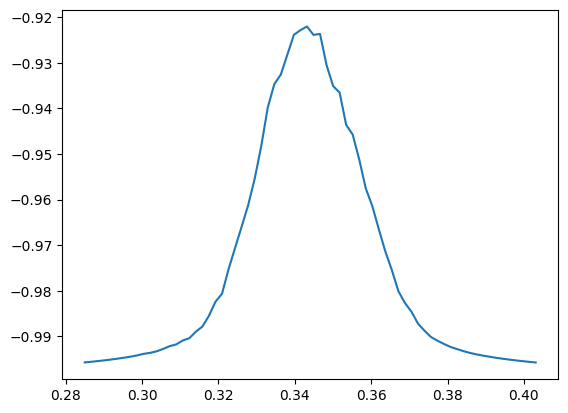

In [203]:
plt.plot(a, data)

In [204]:
print(np.argmax(data))
print(a[np.argmax(data)])

34
0.34316883916440216


In [205]:
def estimate_mod(a_val):
    return jaccard_index(mode(x_voltage_int_flatten + a_val), mode(y_voltage_int_flatten))
def estimate_med_p(a_val):
    return jaccard_index(med_p  я(x_voltage_int_flatten + a_val), med_p(y_voltage_int_flatten))
def estimate_med_k(a_val):
    return jaccard_index(med_k(x_voltage_int_flatten + a_val), med_k(y_voltage_int_flatten))

In [206]:
vec_estimate_mod = np.vectorize(estimate_mod)
vec_estimate_med_p = np.vectorize(estimate_med_p)
vec_estimate_med_k = np.vectorize(estimate_med_k)

In [207]:
data_med_p = vec_estimate_med_p(a)
data_med_k = vec_estimate_med_k(a)

### Интерполированные данные

In [208]:
from scipy.interpolate import interp1d
data = np.array([float(item) for item in data])
data_med_k = np.array([float(item) for item in data_med_k])
data_med_p = np.array([float(item) for item in data_med_p])

In [209]:
def process_data(point_data, a_data):
    max_idx = np.argmax(point_data)
    min_idx = np.argmin(point_data)
    print(f"max y: {point_data[max_idx]}")
    print(f"min y: {point_data[min_idx]}")
    print(f"a: {a_data[max_idx]}")
    f1 = interp1d(np.array(point_data[0:max_idx + 1]), np.array(a_data[0:max_idx + 1]), kind = 'linear')
    f2 = interp1d(np.array(point_data[max_idx:]), np.array(a_data[max_idx:]), kind = 'linear')
    
    plt.plot(a_data, point_data)
    internal_dot = (3 * point_data[max_idx] + point_data[min_idx])/ 4
    print(f"internal: {internal_dot}, x=[{f1(internal_dot)},{f2(internal_dot)}]")
    external_dot = (point_data[max_idx] + 3 * point_data[min_idx])/ 4
    print(f"external: {external_dot}, x=[{f1(external_dot)},{f2(external_dot)}]")
    plt.hlines(internal_dot, f1(internal_dot), f2(internal_dot), linestyles = 'dashed', label = 'internal', colors = 'green')
    plt.hlines(external_dot, f1(external_dot), f2(external_dot), linestyles = 'dashed', label = 'external', colors = 'red')
    plt.legend()

max y: -0.9220330535320916
min y: -0.9957121041227782
a: 0.34316883916440216
internal: -0.9404528161797633, x=[0.332771709970149,0.3526741687174664]
external: -0.9772923414751066, x=[0.32198839592912515,0.3660894096878732]


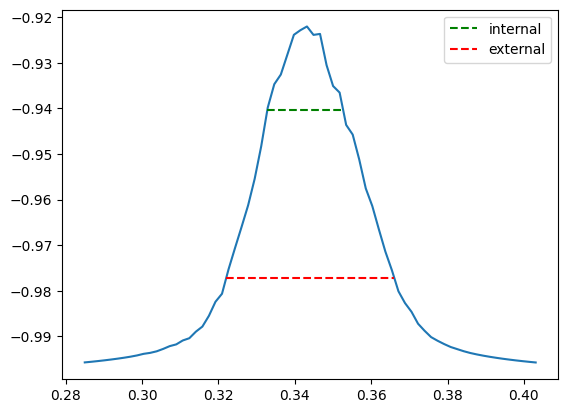

In [210]:
process_data(data, a)

max y: -0.5799086757990954
min y: -0.9959016393442623
a: 0.34316883916440216
internal: -0.6839069166853872, x=[0.3426012315040533,0.3439029350526994]
external: -0.8919033984579706, x=[0.34146601618335565,0.34608834256052484]


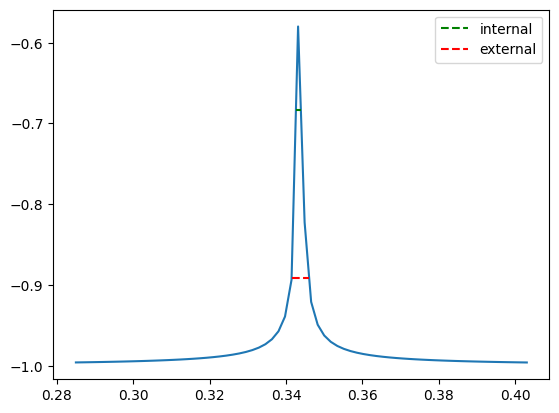

In [211]:
process_data(data_med_k, a)

max y: -0.5799086757990968
min y: -0.9959016393442623
a: 0.34316883916440216
internal: -0.6839069166853882, x=[0.3426012315040533,0.3439029350526994]
external: -0.891903398457971, x=[0.34146601618335565,0.34608834256052484]


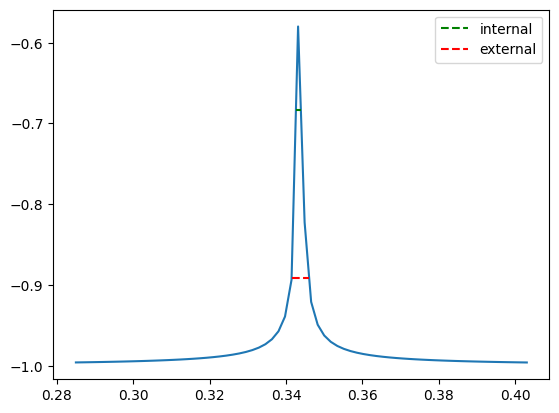

In [212]:
process_data(data_med_p, a)

In [ ]:
data_mod = vec_estimate_mod(a)
data_mod = np.array([float(item) for item in data_mod])

In [ ]:
process_data(data_mod, a)

# t * X = Y

In [269]:
def estimate_t(t_val):
    # vec = np.array(jaccard_sequence_index(x_voltage_int_flatten * t_val, y_voltage_int_flatten))
    # vec += 1 # [-1,1] -> [0,2]
    # vec /= 2 # [0,2] -> [0,1]
    # return np.linalg.norm(vec)
    return np.mean(jaccard_sequence_index(x_voltage_int_flatten * t_val, y_voltage_int_flatten))
vec_estimate_t = np.vectorize(estimate_t)

In [216]:
def estimate_mod_t(t_val):
    return jaccard_index(mode(x_voltage_int_flatten * t_val), mode(y_voltage_int_flatten))
def estimate_med_p_t(t_val):
    return jaccard_index(med_p(x_voltage_int_flatten * t_val), med_p(y_voltage_int_flatten))
def estimate_med_k_t(t_val):
    return jaccard_index(med_k(x_voltage_int_flatten * t_val), med_k(y_voltage_int_flatten))

In [217]:
vec_estimate_mod_t = np.vectorize(estimate_mod_t)
vec_estimate_med_p_t = np.vectorize(estimate_med_k_t)
vec_estimate_med_k_t = np.vectorize(estimate_med_p_t)

In [257]:
def process_data_t(point_data, a_data, show = True):
    max_idx = np.argmax(point_data)
    min_idx = np.argmin(point_data)
    print(f"max y: {point_data[max_idx]}")
    print(f"min y: {point_data[min_idx]}")
    print(f"t: {a_data[max_idx]}")
    plt.plot(a_data, point_data)
    if show:
        f1 = interp1d(np.array(point_data[0:max_idx + 1]), np.array(a_data[0:max_idx + 1]), kind = 'linear')
        f2 = interp1d(np.array(point_data[max_idx:]), np.array(a_data[max_idx:]), kind = 'linear')
        
        internal_dot = (3 * point_data[max_idx] + point_data[min_idx])/ 4
        print(f"internal: {internal_dot}, x=[{f1(internal_dot)},{f2(internal_dot)}]")
        external_dot = (point_data[max_idx] + 3 * point_data[min_idx])/ 4
        print(f"external: {external_dot}, x=[{f1(external_dot)},{f2(external_dot)}]")
        plt.hlines(internal_dot, f1(internal_dot), f2(internal_dot), linestyles = 'dashed', label = 'internal', colors = 'green')
        plt.hlines(external_dot, f1(external_dot), f2(external_dot), linestyles = 'dashed', label = 'external', colors = 'red')
        plt.legend()

### Расширенные границы и количество итераций

In [237]:
# t_bounds = [min(y_voltage_int_flatten, key=lambda x: med(x)) / max(x_voltage_int_flatten, key=lambda x: med(x)),
#            max(y_voltage_int_flatten, key=lambda x: med(x)) / min(x_voltage_int_flatten, key=lambda x: med(x))]
# t_bounds.sort()
# t_bounds = [med(interval) for interval in t_bounds]
# t_bounds[0] -= 0.05
# t_bounds[1] += 0.05
# print(t_bounds)

In [238]:
# iters = 300
# t = np.linspace(t_bounds[0], t_bounds[1], iters)
# print(f"step: {np.abs(t_bounds[1] - t_bounds[0]) / iters}")

In [239]:
# data_med_p_t = vec_estimate_med_p_t(t)
# data_med_k_t = vec_estimate_med_k_t(t)

In [240]:
# data_t = vec_estimate(t)

In [241]:
# data_t = np.array([float(item) for item in data_t])
# data_med_k_t = np.array([float(item) for item in data_med_k_t])
# data_med_p_t = np.array([float(item) for item in data_med_p_t])

In [242]:
# plt.plot(t, data_t) 

In [243]:
# print(np.argmax(data_t))
# print(data_t[np.argmax(data_t)])
# print(t[np.argmax(data_t)])

In [244]:
# process_data_t(data_med_k_t, t)

In [245]:
# process_data_t(data_med_p_t, t)

### Стандартные размеры границ

In [246]:
t_bounds = [min(y_voltage_int_flatten, key=lambda x: med(x)) / max(x_voltage_int_flatten, key=lambda x: med(x)),
           max(y_voltage_int_flatten, key=lambda x: med(x)) / min(x_voltage_int_flatten, key=lambda x: med(x))]
t_bounds.sort()
t_bounds = [med(interval) for interval in t_bounds]
print(t_bounds)

[-1.0509318748246474, -1.0073090554546673]


In [247]:
iters = 70
t = np.linspace(t_bounds[0], t_bounds[1], iters)
print(f"step: {np.abs(t_bounds[1] - t_bounds[0]) / iters}")

step: 0.0006231831338568591


In [248]:
data_med_p_t = vec_estimate_med_p_t(t)
data_med_k_t = vec_estimate_med_k_t(t)

In [270]:
data_t = vec_estimate_t(t)

In [249]:
data_t = np.array([float(item) for item in data_t])
data_med_k_t = np.array([float(item) for item in data_med_k_t])
data_med_p_t = np.array([float(item) for item in data_med_p_t])

max y: -0.925693654215631494378457053315232982
min y: -0.931535832160672780589799537796957455
t: -1.0332298611672641


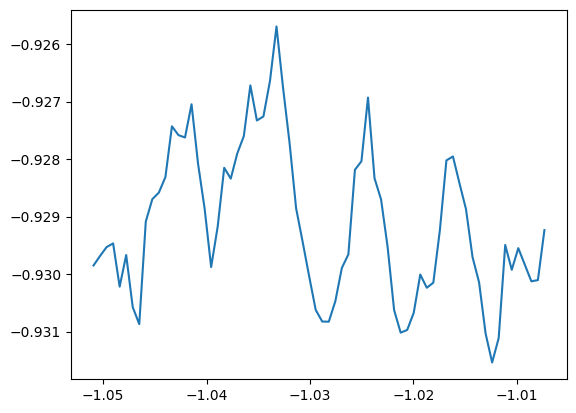

In [271]:
process_data_t(data_t, t, False)

In [251]:
print(np.argmax(data_t))
print(data_t[np.argmax(data_t)])
print(t[np.argmax(data_t)])

28
-0.9256936542156315
-1.0332298611672641


max y: 0.8754691268198553
min y: -0.9607121953830408
t: -1.014263417962925
internal: 0.4164237962691313, x=[-1.014639896134991,-1.0139206337934443]
external: -0.5016668648323167, x=[-1.016519801447331,-1.0121102237277046]


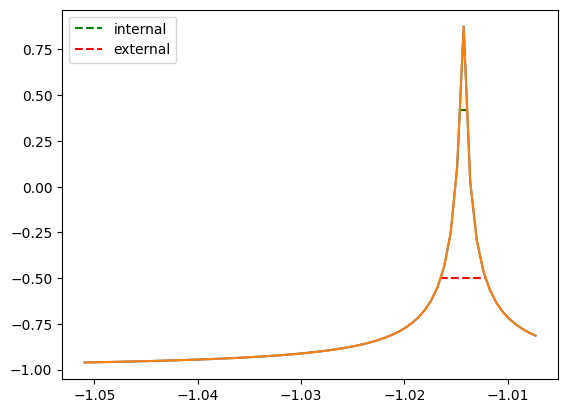

In [252]:
process_data_t(data_med_k_t, t)

max y: 0.8754691268199107
min y: -0.9607121953830385
t: -1.014263417962925
internal: 0.41642379626917336, x=[-1.014639896134991,-1.0139206337934443]
external: -0.5016668648323012, x=[-1.016519801447331,-1.0121102237277046]


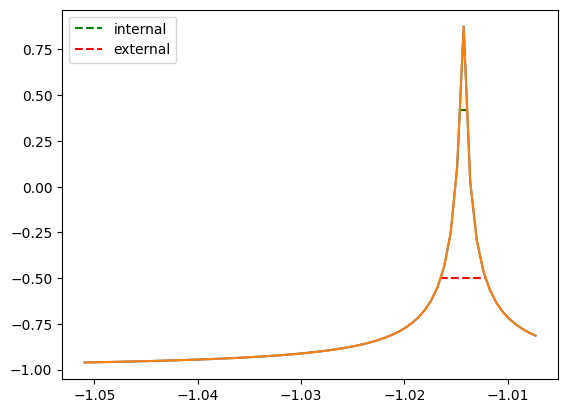

In [253]:
process_data_t(data_med_p_t, t)